<a href="https://colab.research.google.com/github/RManisha27/youtube-ad-predictor/blob/main/youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving youtube_ad_revenue_dataset.csv to youtube_ad_revenue_dataset.csv
User uploaded file "youtube_ad_revenue_dataset.csv" with length 16222230 bytes


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Install streamlit for the web app phase
!pip install streamlit -q

# Load the dataset (Ensure you have uploaded the CSV to your Colab files)
# The dataset has ~122,000 rows [cite: 47]

file_name = 'YouTube_Monetization_Modeler.csv'

if not os.path.exists(file_name):
    print(f"The file '{file_name}' was not found.")
    print("Please upload the CSV file using the file explorer (folder icon on the left sidebar) or run the following code to upload:")
    print("from google.colab import files")
    print("uploaded = files.upload()")
    print("for fn in uploaded.keys():")
    print("    print(f'User uploaded file \"{fn}\" with length {len(uploaded[fn])} bytes')")
    df = None # Set df to None or an empty DataFrame to prevent further errors
else:
    df = pd.read_csv(file_name)
    print(f"'{file_name}' loaded successfully.")

'YouTube_Monetization_Modeler.csv' loaded successfully.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   video_id              122400 non-null  object 
 1   date                  122400 non-null  object 
 2   views                 122400 non-null  int64  
 3   likes                 116283 non-null  float64
 4   comments              116288 non-null  float64
 5   watch_time_minutes    116295 non-null  float64
 6   video_length_minutes  122400 non-null  float64
 7   subscribers           122400 non-null  int64  
 8   category              122400 non-null  object 
 9   device                122400 non-null  object 
 10  country               122400 non-null  object 
 11  ad_revenue_usd        122400 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 11.2+ MB
None
               views          likes       comments  watch_time_minutes  \
count  122400.00000

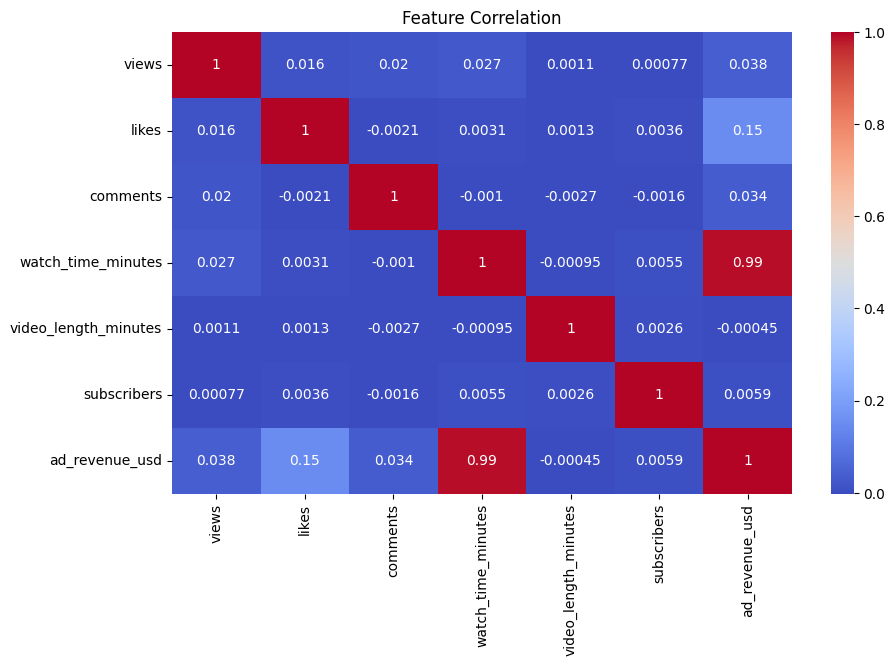

In [4]:
# Basic inspection [cite: 15]
print(df.info())
print(df.describe())

# Check for missing values (Requirement: Handle ~5% missing) [cite: 63]
print("Missing Values:\n", df.isnull().sum())

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [5]:
# 1. Remove ~2% duplicated records [cite: 64]
df.drop_duplicates(inplace=True)

# 2. Feature Engineering: Create engagement rate [cite: 19]
# Formula: (likes + comments) / views [cite: 19]
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views'].replace(0, 1)

# 3. Define Features and Target [cite: 50, 61]
# Categorical columns: category, device, country [cite: 66]
categorical_cols = ['category', 'device', 'country']
numerical_cols = ['views', 'likes', 'comments', 'watch_time_minutes',
                  'video_length_minutes', 'subscribers', 'engagement_rate']
target = 'ad_revenue_usd'

X = df[categorical_cols + numerical_cols]
y = df[target]

# 4. Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Create a preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing values [cite: 63]
    ('scaler', StandardScaler()) # Normalize/Scale features [cite: 67]
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Categorical encoding [cite: 66]
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# List of 5 models to compare [cite: 20]
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Ridge Regression": LinearRegression() # Placeholder for 5th model
}

# Training and Evaluation [cite: 21]
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"--- {name} ---")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}") # [cite: 34]
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}") # [cite: 36]
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}") # [cite: 35]

# Save the best model (e.g., Random Forest)
best_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor())])
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'youtube_model.pkl')

--- Linear Regression ---
R2 Score: 0.9526
MAE: 3.1046
RMSE: 13.4792
--- Decision Tree ---
R2 Score: 0.8942
MAE: 5.5542
RMSE: 20.1368
--- Random Forest ---
R2 Score: 0.9500
MAE: 3.5747
RMSE: 13.8461
--- Gradient Boosting ---
R2 Score: 0.9522
MAE: 3.6970
RMSE: 13.5343
--- Ridge Regression ---
R2 Score: 0.9526
MAE: 3.1046
RMSE: 13.4792


['youtube_model.pkl']

In [7]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Define the subdirectory where model and data are stored
MODEL_DATA_DIR = 'my_youtube_predictor'

# Load the model
model_path = os.path.join(MODEL_DATA_DIR, 'youtube_model.pkl')
model = joblib.load(model_path)

# Load the original dataset to get the distribution for the plot
file_name = os.path.join(MODEL_DATA_DIR, 'YouTube_Monetization_Modeler.csv')
if os.path.exists(file_name):
    original_df = pd.read_csv(file_name)
else:
    original_df = pd.DataFrame({'ad_revenue_usd': []}) # Empty DataFrame if file not found

st.title("📹 YouTube Ad Revenue Predictor")
st.write("Adjust the parameters to estimate potential ad revenue.")

# Input fields
views = st.number_input("Views", min_value=0, value=10000)
likes = st.number_input("Likes", min_value=0, value=1100)
comments = st.number_input("Comments", min_value=0, value=274)
watch_time = st.slider("Watch Time (Minutes)", min_value=10000.0, max_value=70000.0, value=37500.0, step=100.0)
vid_length = st.number_input("Video Length (Minutes)", min_value=0.0, value=16.0)
subs = st.number_input("Subscribers", min_value=0, value=500000)
cat = st.selectbox("Category", ['Gaming', 'Education', 'Entertainment', 'Tech', 'Music', 'Lifestyle'])
dev = st.selectbox("Device", ['Mobile', 'Desktop', 'Tablet'])
country = st.selectbox("Country", ['USA', 'India', 'UK', 'Brazil', 'CA', 'DE', 'AU'])

# Calculate engagement_rate for the model
engagement_rate = (likes + comments) / views if views > 0 else 0

# Predict revenue dynamically
input_data = pd.DataFrame([[cat, dev, country, views, likes, comments, watch_time, vid_length, subs, engagement_rate]],
                          columns=['category', 'device', 'country', 'views', 'likes', 'comments',
                                   'watch_time_minutes', 'video_length_minutes', 'subscribers', 'engagement_rate'])
prediction = model.predict(input_data)[0] # Get the single prediction value

st.success(f"Estimated Ad Revenue: **${prediction:.2f} USD**")

# Add a visualization showing the prediction in context
st.subheader("Predicted Revenue in Context")

if not original_df.empty:
    fig_pred, ax_pred = plt.subplots(figsize=(8, 4))
    ax_pred.hist(original_df['ad_revenue_usd'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax_pred.axvline(prediction, color='red', linestyle='--', linewidth=2, label=f'Your Prediction: ${prediction:.2f}')
    ax_pred.set_title('Distribution of Ad Revenue with Your Prediction')
    ax_pred.set_xlabel('Ad Revenue (USD)')
    ax_pred.set_ylabel('Frequency')
    ax_pred.legend()
    st.pyplot(fig_pred)
else:
    st.warning("Could not load original dataset for contextual visualization.")

st.subheader("Distribution of Video Categories (Percentage)")
if not original_df.empty:
    category_counts = original_df['category'].value_counts(normalize=True) * 100
    fig_cat, ax_cat = plt.subplots(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis', ax=ax_cat)
    ax_cat.set_title('Distribution of Video Categories (Percentage)')
    ax_cat.set_xlabel('Category')
    ax_cat.set_ylabel('Percentage (%)')
    ax_cat.set_xticklabels(ax_cat.get_xticklabels(), rotation=45, ha='right')

    for index, value in enumerate(category_counts.values):
        ax_cat.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    st.pyplot(fig_cat)
else:
    st.warning("Could not load original dataset for category distribution visualization.")

# Add a new plot: Correlation Heatmap
st.subheader("Feature Correlation Heatmap")
if not original_df.empty:
    # Select only numeric columns for correlation
    numeric_df = original_df.select_dtypes(include=np.number)
    fig_corr, ax_corr = plt.subplots(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', ax=ax_corr)
    ax_corr.set_title("Feature Correlation")
    st.pyplot(fig_corr)
else:
    st.warning("Could not load original dataset for correlation heatmap.")

st.write("---")
st.write("Note: This is an estimation based on the trained model. Actual revenue may vary.")


Writing app.py


In [15]:
# Install pyngrok if not already installed
!pip install pyngrok -q

import subprocess
import threading
from pyngrok import ngrok
import time

def run_streamlit():
    # Adding server options for better compatibility behind a proxy
    subprocess.run(["streamlit", "run", "app.py",
                    "--server.enableCORS=True",
                    "--server.enableXsrfProtection=False"], check=True)

print("Starting Streamlit app...")
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# IMPORTANT: Set ngrok auth token before connecting
ngrok.set_auth_token("371IRqoqbipmPzmoeJrsebuua3H_25nUEkEq2HdVz6imBSXuJ")

# Wait for Streamlit to start up - increased sleep duration
time.sleep(10) # Give Streamlit more time to initialize

# Open a ngrok tunnel to the Streamlit port
try:
    public_url = ngrok.connect(8501)
    print(f"Streamlit App URL: {public_url}")
except Exception as e:
    print(f"Error opening ngrok tunnel: {e}")
    print("You may need to visit https://dashboard.ngrok.com/get-started/your-authtoken to get an auth token if you encounter repeated issues.")


Starting Streamlit app...
Streamlit App URL: NgrokTunnel: "https://nonroyal-maura-magisterial.ngrok-free.dev" -> "http://localhost:8501"


In [16]:
import os
import shutil

# Define the subdirectory where model and data are to be stored
MODEL_DATA_DIR = 'my_youtube_predictor'

# Create the directory if it doesn't exist
if not os.path.exists(MODEL_DATA_DIR):
    os.makedirs(MODEL_DATA_DIR)
    print(f"Directory '{MODEL_DATA_DIR}' created.")
else:
    print(f"Directory '{MODEL_DATA_DIR}' already exists.")

# Define source and destination paths for the model file
source_model_path = 'youtube_model.pkl'
dest_model_path = os.path.join(MODEL_DATA_DIR, 'youtube_model.pkl')

# Move the model file if it exists and is not already in the target directory
if os.path.exists(source_model_path) and not os.path.exists(dest_model_path):
    shutil.move(source_model_path, dest_model_path)
    print(f"Moved '{source_model_path}' to '{dest_model_path}'.")
elif os.path.exists(dest_model_path):
    print(f"'{source_model_path}' is already in '{MODEL_DATA_DIR}'.")
else:
    print(f"Warning: '{source_model_path}' not found in the root directory.")

# Define source and destination paths for the dataset file
source_data_path = 'YouTube_Monetization_Modeler.csv'
dest_data_path = os.path.join(MODEL_DATA_DIR, 'YouTube_Monetization_Modeler.csv')

# Move the dataset file if it exists and is not already in the target directory
if os.path.exists(source_data_path) and not os.path.exists(dest_data_path):
    shutil.move(source_data_path, dest_data_path)
    print(f"Moved '{source_data_path}' to '{dest_data_path}'.")
elif os.path.exists(dest_data_path):
    print(f"'{source_data_path}' is already in '{MODEL_DATA_DIR}'.")
else:
    print(f"Warning: '{source_data_path}' not found in the root directory.")


Directory 'my_youtube_predictor' created.
Moved 'youtube_model.pkl' to 'my_youtube_predictor/youtube_model.pkl'.
Moved 'YouTube_Monetization_Modeler.csv' to 'my_youtube_predictor/YouTube_Monetization_Modeler.csv'.


In [14]:
from pyngrok import ngrok
# IMPORTANT: Replace "YOUR_NGROK_AUTH_TOKEN" with your actual token from https://dashboard.ngrok.com/get-started/your-authtoken
# This line needs to be run once per Colab session if you're using ngrok.
ngrok.set_auth_token("371IRqoqbipmPzmoeJrsebuua3H_25nUEkEq2HdVz6imBSXuJ")

# Now, re-run the previous cell (MUkvJsGJN7Eu) to launch your Streamlit app with the authenticated ngrok tunnel.
